#EECS 442/504 PS5: Scene Recognition

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Bernardo Bianco Prado, beprado

__Important__: after you download the .ipynb file, please name it as __\<your_uniqname\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.




__Note__: There are cells in this notebook that are specific to 504 students, if you are a 442 student please delete/comment them out while submitting the notebook/the pdf file.


# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm
  
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113
Using the GPU!


# Problem 5.1 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Construct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [2]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab. 
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2022-10-10 19:05:47--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip’

data_miniplaces_mod 100%[===================>] 509.86M  5.50MB/s    in 4m 31s  

2022-10-10 19:10:20 (1.88 MB/s) - ‘data_miniplaces_modified.zip’ saved [534628730/534628730]



In [3]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient. 
!unzip -q data_miniplaces_modified.zip

## Step 1: Build dataloaders for train, val, and test

In [4]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    """
    Build dataloaders with transformations.

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.
    """

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    ###########################################################################
    # TODO: Step 1: Build transformations for the dataset.                    #
    # You need to construct a data transformation that does three             #
    # preprocessing steps in order:                                           #
    # I. Resize the image to input_size using transforms.Resize               #
    # II. Convert the image to PyTorch tensor using transforms.ToTensor       #
    # III. Normalize the images with the provided mean and std parameters     #
    # using transforms.Normalize. These parameters are accumulated from a     #
    # large number of training samples.                                       #
    # You can use transforms.Compose to combine the above three               #
    # transformations. Store the combined transforms in the variable          #
    # 'composed_transform'.                                                   #
    ###########################################################################

    resize = transforms.Resize((input_size))
    convert_to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean, std)
    composed_transform = transforms.Compose([resize, 
                                             convert_to_tensor, 
                                             normalize])
    
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    # We write the remaining part of the dataloader for you.  
    # You are encouraged to go through this.

    ###########################################################################
    # Step 2: Build dataloaders.                                              #
    # I. We use torch.datasets.ImageFolder with the provided data_dir and the #
    # data transfomations you created in step 1 to construct pytorch datasets #
    # for training, validation, and testing.                                  #
    # II. Then we use torch.utils.data.DataLoader to build dataloaders with   #
    # the constructed pytorch datasets. You need to enable shuffling for      #
    # the training set. Set num_workers=2 to speed up dataloading.            #
    # III. Finally, we put the dataloaders into a dictionary.                 #
    ###########################################################################

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}

    return dataloaders_dict

In [5]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 90000
# of validation samples 10000
# of test samples 10000


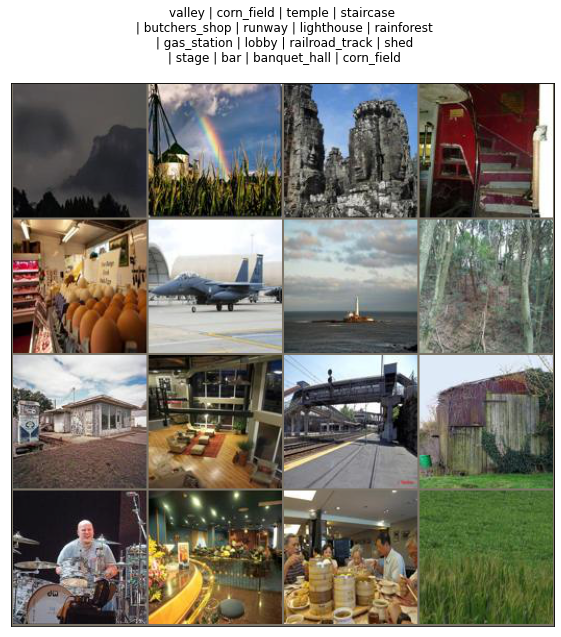

In [6]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(10, 10)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## Step 2. Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown below.

__MiniVGG architecture__

![alt text](https://drive.google.com/uc?id=1RF3CjEsHBpRjubqwgBUxIEv54gpDjt95)

__MiniVGG-BN architecure__

![alt text](https://drive.google.com/uc?id=1HR5N2V-5RVT1u_bVzyCvhPJZ7PSnYm6x)


In [7]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    """
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    """

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [8]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output 
# channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):
  """
  Return a nn.Sequential object containing all layers to get the features 
  using the CNN. (That is, before the Average pooling layer in the two 
  pictures above). 

  Args:
    cfg: list
    batch_norm: bool, default: False. If set to True, a BatchNorm layer 
                should be added after each convolutional layer.

  Return:
    features: torch.nn.Sequential. Containers for all feature extraction
              layers. For use of torch.nn.Sequential, please refer to 
              PyTorch documentation.
  """
  ###########################################################################
  # TODO: Construct the neural net architecture from cfg. You should use    #
  # nn.Sequential().                                                        #
  ###########################################################################

  # convolution layers
  conv = lambda in_channels, out_channels : nn.Conv2d(in_channels, 
                                                      out_channels, 
                                                      kernel_size=(3,3),
                                                      stride = (1,1),
                                                      padding = (1,1))
  # batch normalization layers
  batch_normalization = lambda in_channels : nn.BatchNorm2d(in_channels,
                                                    eps = 1e-05,
                                                    momentum = 0.1,
                                                    affine = True,
                                                    track_running_stats = True)
  # max pooling layers
  max_pool = nn.MaxPool2d(kernel_size = 2, 
                          stride = 2,
                          padding = 0,
                          dilation = 1,
                          ceil_mode = False)


  # list that holds the sequence of models for the features variable
  modules = []  # nn.ModuleList()
  
  # start with 3 colors
  in_channels = 3
  for element in cfg:
    # if the element is an integer, then it's a convolution layer
    if type(element) == int:
      modules.append(conv(in_channels, element))
      if batch_norm: 
        modules.append(batch_normalization(element))
      modules.append(nn.ReLU(inplace = True))
      in_channels = element
    # else it's a max pooling layer
    elif element == 'M':
      modules.append(max_pool)
  
  features = nn.Sequential(*modules)

  ###########################################################################
  #                              END OF YOUR CODE                           #
  ###########################################################################

  return features

class VGG(nn.Module):

  def __init__(self, features, num_classes=100, init_weights=True):
    super(VGG, self).__init__()

    self.features = features
    self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

    #######################################################################
    # TODO: Construct the final FC layers using nn.Sequential.            #
    # Note: The average pooling layer has been defined by us above.       #
    #######################################################################        
    self.classifier = nn.Sequential(nn.Linear(in_features = 3200, out_features = 512, bias = True),
                                    nn.ReLU(inplace = True),
                                    nn.Dropout(p = 0.3, inplace = False),
                                    nn.Linear(in_features = 512, out_features = 256, bias = True),
                                    nn.ReLU(inplace = True),
                                    nn.Dropout(p = 0.3, inplace = False),
                                    nn.Linear(in_features = 256, out_features = 100, bias = True))
                                    
    #######################################################################
    #                              END OF YOUR CODE                       #
    #######################################################################

    if init_weights:
      self._initialize_weights() 

  def forward(self, x): 
      x = self.features(x)
      x = self.avgpool(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.normal_(m.weight, 0, 0.01)
              nn.init.constant_(m.bias, 0)

In [ ]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with 
# the one given in the instructions above. 
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

## Step 3. Build small ResNet model (EECS 504)

Please follow this figure to build the Residual Block and the Resnet model. We already implemented the back bone of the resnet model. You have to code the ResNet Block and the classifier part which are shown in the figure.

__ResNet architecture__

![alt text](https://drive.google.com/uc?id=1IlNfXwxYzTJC3FtmydDs07Z5Z9IWatde)





In [9]:
# For EECS 504 students only other please delete/comment this cell

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(ResidualBlock, self).__init__()
        ###########################################################################
        # TODO: Code the residual block as depicted in the above figure. You should use    #
        # nn.Sequential().                                                        #
        ###########################################################################
        self.block_seq = nn.Sequential(
                      nn.Conv2d(in_channels, in_channels, kernel_size=(3,3), stride=stride, padding = 1),
                      nn.BatchNorm2d(in_channels),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=stride, padding = 1),
                      nn.BatchNorm2d(out_channels),
                                  )
        self.relu = nn.ReLU()
        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################
        
    def forward(self, x):

        ###########################################################################
        # TODO: Code the forward pass for the residual block as depicted in the above figure. 
        # Note: The relu activation function is after the skip connection.                                                        #
        ###########################################################################

        x_copy = x.clone()
        x = self.block_seq(x)
        x = x + x_copy
        x = self.relu(x)

        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################
        return x

In [10]:
# For EECS 504 students only other please delete/comment this cell

class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes = 100):
    super(ResNet, self).__init__()

    ###########################################################################
    # TODO: Construct the neural net architecture for the resnet model. You should use nn.Sequential().
    # Note: We already implemented most of the network you just need to code the initial layers and insert the residual blocks.
    ###########################################################################

    self.backbone = nn.Sequential(
                    ###########################################################################
                    # TODO: Code the initial layers i.e the the strided convolution layer, batchnorm, relu, maxpool layer and the residual blocks
                    #Hint: you have to make use of the "block" variable.
                    ###########################################################################
                    nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.MaxPool2d(3, stride=2, padding=1)),
                    nn.Sequential(*[block(64,64) for i in range(layers[0])]),
                    #######################################################################
                    #                              END OF YOUR CODE                       #
                    #######################################################################
                    nn.Sequential(
                    nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
                    nn.BatchNorm2d(128),
                    nn.ReLU()),
                    ###########################################################################
                    # TODO: Inser the residual block please follow the figure for the number of channels and the flow of layers.
                    ###########################################################################
                    nn.Sequential(*[block(128,128) for i in range(layers[1])]),
                    #######################################################################
                    #                              END OF YOUR CODE                       #
                    #######################################################################
                    nn.Sequential(
                    nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
                    nn.BatchNorm2d(256),
                    nn.ReLU()),
                    ###########################################################################
                    # TODO: Inser the residual block please follow the figure for the number of channels and the flow of layers.
                    ###########################################################################
                    nn.Sequential(*[block(256,256) for i in range(layers[2])]),
                    #######################################################################
                    #                              END OF YOUR CODE                       #
                    #######################################################################
                    nn.Sequential(
                    nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = 1),
                    nn.BatchNorm2d(512),
                    nn.ReLU()),
                    ###########################################################################
                    # TODO: Inser the residual block please follow the figure for the number of channels and the flow of layers.
                    ###########################################################################
                    nn.Sequential(*[block(512,512) for i in range(layers[3])]),
                    #######################################################################
                    #                              END OF YOUR CODE                       #
                    #######################################################################
    )
    

    self.avgpool = nn.AvgPool2d(2, stride=1)
    #self.avgpool = nn.AvgPool2d(4)
    self.fc = nn.Linear(512, num_classes)
      

  def forward(self, x):

    x = self.backbone(x)
    #print("DONE WITH FOURTH LAYER", x.shape)
    x = self.avgpool(x)
    #print("DONE WITH AVERAGE POOLING!", x.shape)
    x = x.view(x.size(0), -1)
    #print("RESHAPED X!", x.shape)
    x = self.fc(x)
    #print("DONE WITH FULLY CONNECTED LAYER!", x.shape)

    return x

In [11]:
# For EECS 504 students only other please delete/comment this cell

resnet = ResNet(ResidualBlock, [1, 1, 1, 1], 100)
print(resnet)
print('Number of trainable parameters {}'.format(count_params(resnet)))


ResNet(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): ResidualBlock(
        (block_seq): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, aff

## Step 4: Build training/validation loops

You will write a function for training and validating the network. 

In [13]:
def make_optimizer(model):
    """
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    """
    ###########################################################################
    # TODO: Create a SGD optimizer with learning rate=1e-2 and momentum=0.9.  #
    # HINT: Check out optim.SGD() and initialize it with the appropriate      #
    # parameters. We have imported torch.optim as optim for you above.        #
    ###########################################################################

    optimizer = optim.SGD(model.parameters(), lr = 1e-2, momentum = 0.9)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return optimizer

def get_loss():
    """
    Returns:
        criterion: pytorch loss. 
    """
    ###########################################################################
    # TODO: Create an instance of the cross entropy loss. This code           #
    # should be a one-liner.                                                  #
    ###########################################################################
    criterion = nn.CrossEntropyLoss()
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return criterion

In [14]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    """
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    """

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                ###############################################################
                # TODO:                                                       #
                # Please read all the inputs carefully!                       #
                # For "train" phase:                                          #
                # (i)   Compute the outputs using the model                   #
                #       Also, use the  outputs to calculate the class         #
                #       predicted by the model,                               #
                #       Store the predicted class in 'preds'                  #
                #       (Think: argmax of outputs across a dimension)         #
                #       torch.max() might help!                               #
                # (ii)  Use criterion to store the loss in 'loss'             # 
                # (iii) Update the model parameters                           #
                # Notes:                                                      #
                # - Don't forget to zero the gradients before beginning the   #
                # loop!                                                       #
                # - "val" phase is the same as train, but without backprop    #
                # - Compute the outputs (Same as "train", calculate 'preds'   #
                # too),                                                       #
                # - Calculate the loss and store it in 'loss'                 #
                ###############################################################
                
                # zero the gradient
                #optimizer.zero_grad()
                optimizer.zero_grad()
                # forward pass
                outputs = model(inputs)
                _ , preds = torch.max(outputs, 1)
                if phase == "train":
                  # compute loss
                  loss = criterion(outputs, labels)
                  # back propagation and update
                  loss.backward()
                  optimizer.step()

                ###############################################################
                #                         END OF YOUR CODE                    #
                ###############################################################

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # =========================================================== #
                # IMPORTANT:
                # Losing your connection to colab will lead to loss of trained 
                # weights.
                # You should download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to 
                # train the neural networks again.
                # =========================================================== #
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## Step 5. Train MiniVGG / MiniVGG-BN and ResNet model (EECS 504)

In [15]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloaders and criterion function
input_size = 64
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [ ]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

Epoch 0/19
----------


100%|██████████| 704/704 [01:18<00:00,  8.93it/s]


train Loss: 4.5440 Acc: 0.0154


100%|██████████| 79/79 [00:07<00:00, 10.31it/s]


val Loss: 4.3553 Acc: 0.0324
Epoch 1/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.07it/s]


train Loss: 4.1320 Acc: 0.0578


100%|██████████| 79/79 [00:07<00:00, 10.43it/s]


val Loss: 4.0939 Acc: 0.0870
Epoch 2/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.82it/s]


train Loss: 3.8070 Acc: 0.1063


100%|██████████| 79/79 [00:07<00:00, 10.54it/s]


val Loss: 3.5176 Acc: 0.1339
Epoch 3/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.14it/s]


train Loss: 3.5915 Acc: 0.1407


100%|██████████| 79/79 [00:07<00:00, 10.59it/s]


val Loss: 3.3020 Acc: 0.1598
Epoch 4/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.92it/s]


train Loss: 3.4028 Acc: 0.1723


100%|██████████| 79/79 [00:07<00:00, 10.57it/s]


val Loss: 3.1390 Acc: 0.1951
Epoch 5/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.93it/s]


train Loss: 3.2564 Acc: 0.1970


100%|██████████| 79/79 [00:07<00:00, 10.56it/s]


val Loss: 2.5592 Acc: 0.2158
Epoch 6/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.99it/s]


train Loss: 3.1282 Acc: 0.2216


100%|██████████| 79/79 [00:07<00:00, 10.60it/s]


val Loss: 2.7095 Acc: 0.2272
Epoch 7/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.07it/s]


train Loss: 3.0150 Acc: 0.2419


100%|██████████| 79/79 [00:07<00:00, 10.50it/s]


val Loss: 3.0632 Acc: 0.2566
Epoch 8/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.15it/s]


train Loss: 2.9034 Acc: 0.2641


100%|██████████| 79/79 [00:07<00:00, 10.45it/s]


val Loss: 2.8788 Acc: 0.2663
Epoch 9/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.13it/s]


train Loss: 2.7981 Acc: 0.2857


100%|██████████| 79/79 [00:07<00:00, 10.42it/s]


val Loss: 3.0745 Acc: 0.2879
Epoch 10/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.78it/s]


train Loss: 2.7189 Acc: 0.3028


100%|██████████| 79/79 [00:07<00:00, 10.35it/s]


val Loss: 2.7377 Acc: 0.2966
Epoch 11/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.00it/s]


train Loss: 2.6181 Acc: 0.3209


100%|██████████| 79/79 [00:07<00:00, 10.59it/s]


val Loss: 2.6248 Acc: 0.2909
Epoch 12/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.94it/s]


train Loss: 2.5357 Acc: 0.3410


100%|██████████| 79/79 [00:07<00:00, 10.54it/s]


val Loss: 2.6821 Acc: 0.3171
Epoch 13/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.08it/s]


train Loss: 2.4469 Acc: 0.3585


100%|██████████| 79/79 [00:07<00:00, 10.66it/s]


val Loss: 3.4493 Acc: 0.3107
Epoch 14/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.10it/s]


train Loss: 2.3722 Acc: 0.3713


100%|██████████| 79/79 [00:07<00:00, 10.51it/s]


val Loss: 1.9006 Acc: 0.3169
Epoch 15/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.95it/s]


train Loss: 2.2733 Acc: 0.3936


100%|██████████| 79/79 [00:07<00:00, 10.50it/s]


val Loss: 2.4912 Acc: 0.3194
Epoch 16/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.00it/s]


train Loss: 2.1916 Acc: 0.4093


100%|██████████| 79/79 [00:07<00:00, 10.52it/s]


val Loss: 2.7226 Acc: 0.3251
Epoch 17/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.73it/s]


train Loss: 2.1249 Acc: 0.4250


100%|██████████| 79/79 [00:07<00:00, 10.37it/s]


val Loss: 2.5178 Acc: 0.3193
Epoch 18/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.08it/s]


train Loss: 2.0424 Acc: 0.4417


100%|██████████| 79/79 [00:07<00:00, 10.57it/s]


val Loss: 2.1204 Acc: 0.3253
Epoch 19/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.98it/s]


train Loss: 1.9609 Acc: 0.4582


100%|██████████| 79/79 [00:07<00:00, 10.36it/s]

val Loss: 1.7664 Acc: 0.3224
Best val Acc: 0.325300


In [ ]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

Epoch 0/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.84it/s]


train Loss: 4.2043 Acc: 0.0477


100%|██████████| 79/79 [00:07<00:00, 10.72it/s]


val Loss: 4.2670 Acc: 0.0834
Epoch 1/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.00it/s]


train Loss: 3.6317 Acc: 0.1242


100%|██████████| 79/79 [00:07<00:00, 10.67it/s]


val Loss: 3.6460 Acc: 0.1610
Epoch 2/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.98it/s]


train Loss: 3.3508 Acc: 0.1736


100%|██████████| 79/79 [00:07<00:00, 10.72it/s]


val Loss: 3.2304 Acc: 0.1941
Epoch 3/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.90it/s]


train Loss: 3.1870 Acc: 0.2040


100%|██████████| 79/79 [00:07<00:00, 10.37it/s]


val Loss: 2.6236 Acc: 0.2119
Epoch 4/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.82it/s]


train Loss: 3.0623 Acc: 0.2311


100%|██████████| 79/79 [00:07<00:00, 10.48it/s]


val Loss: 3.3057 Acc: 0.2448
Epoch 5/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.86it/s]


train Loss: 2.9503 Acc: 0.2511


100%|██████████| 79/79 [00:07<00:00, 10.46it/s]


val Loss: 3.1714 Acc: 0.2622
Epoch 6/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.79it/s]


train Loss: 2.8601 Acc: 0.2701


100%|██████████| 79/79 [00:07<00:00, 10.56it/s]


val Loss: 2.6155 Acc: 0.2737
Epoch 7/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.73it/s]


train Loss: 2.7854 Acc: 0.2859


100%|██████████| 79/79 [00:07<00:00, 10.65it/s]


val Loss: 1.8231 Acc: 0.2851
Epoch 8/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.02it/s]


train Loss: 2.7046 Acc: 0.3035


100%|██████████| 79/79 [00:07<00:00, 10.69it/s]


val Loss: 3.1052 Acc: 0.3035
Epoch 9/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.71it/s]


train Loss: 2.6351 Acc: 0.3175


100%|██████████| 79/79 [00:10<00:00,  7.36it/s]


val Loss: 2.7980 Acc: 0.3056
Epoch 10/19
----------


100%|██████████| 704/704 [01:19<00:00,  8.87it/s]


train Loss: 2.5615 Acc: 0.3311


100%|██████████| 79/79 [00:07<00:00, 10.72it/s]


val Loss: 3.2049 Acc: 0.3245
Epoch 11/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.61it/s]


train Loss: 2.5054 Acc: 0.3456


100%|██████████| 79/79 [00:07<00:00, 10.36it/s]


val Loss: 2.7486 Acc: 0.2963
Epoch 12/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.89it/s]


train Loss: 2.4366 Acc: 0.3576


100%|██████████| 79/79 [00:07<00:00, 10.54it/s]


val Loss: 3.5201 Acc: 0.3316
Epoch 13/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.92it/s]


train Loss: 2.3717 Acc: 0.3723


100%|██████████| 79/79 [00:07<00:00, 10.51it/s]


val Loss: 2.8549 Acc: 0.3284
Epoch 14/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.90it/s]


train Loss: 2.3182 Acc: 0.3845


100%|██████████| 79/79 [00:07<00:00, 10.65it/s]


val Loss: 2.8119 Acc: 0.3434
Epoch 15/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.00it/s]


train Loss: 2.2610 Acc: 0.3964


100%|██████████| 79/79 [00:07<00:00, 10.63it/s]


val Loss: 2.0548 Acc: 0.3376
Epoch 16/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.07it/s]


train Loss: 2.2000 Acc: 0.4076


100%|██████████| 79/79 [00:07<00:00, 10.56it/s]


val Loss: 2.1340 Acc: 0.3545
Epoch 17/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.92it/s]


train Loss: 2.1453 Acc: 0.4191


100%|██████████| 79/79 [00:07<00:00, 10.57it/s]


val Loss: 2.2152 Acc: 0.3640
Epoch 18/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.96it/s]


train Loss: 2.0934 Acc: 0.4326


100%|██████████| 79/79 [00:07<00:00, 10.57it/s]


val Loss: 2.2804 Acc: 0.3605
Epoch 19/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.03it/s]


train Loss: 2.0384 Acc: 0.4442


100%|██████████| 79/79 [00:07<00:00, 10.64it/s]

val Loss: 1.9053 Acc: 0.3707
Best val Acc: 0.370700


In [16]:
# For EECS 504 students only other please delete/comment this cell

# Initialize ResNet
resnet = ResNet(ResidualBlock, [1, 1, 1, 1], num_classes).to(device)
optimizer = make_optimizer(resnet)
# Train the model!
resnet, tr_his_res, val_his_res = train_model(model=resnet, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='ResNet')

Epoch 0/19
----------


100%|██████████| 704/704 [01:18<00:00,  9.01it/s]


train Loss: 3.6910 Acc: 0.1301


100%|██████████| 79/79 [00:07<00:00, 10.69it/s]


val Loss: 3.3480 Acc: 0.1753
Epoch 1/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.68it/s]


train Loss: 3.1697 Acc: 0.2176


100%|██████████| 79/79 [00:07<00:00, 10.39it/s]


val Loss: 2.8665 Acc: 0.2149
Epoch 2/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.08it/s]


train Loss: 2.8849 Acc: 0.2703


100%|██████████| 79/79 [00:07<00:00, 10.88it/s]


val Loss: 2.8656 Acc: 0.2474
Epoch 3/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.85it/s]


train Loss: 2.6537 Acc: 0.3160


100%|██████████| 79/79 [00:07<00:00, 10.91it/s]


val Loss: 3.1331 Acc: 0.2681
Epoch 4/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.02it/s]


train Loss: 2.4442 Acc: 0.3603


100%|██████████| 79/79 [00:07<00:00, 10.87it/s]


val Loss: 2.5524 Acc: 0.2698
Epoch 5/19
----------


100%|██████████| 704/704 [01:09<00:00, 10.11it/s]


train Loss: 2.2218 Acc: 0.4096


100%|██████████| 79/79 [00:08<00:00,  8.98it/s]


val Loss: 1.6154 Acc: 0.2958
Epoch 6/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.90it/s]


train Loss: 1.9880 Acc: 0.4587


100%|██████████| 79/79 [00:07<00:00, 10.26it/s]


val Loss: 2.5075 Acc: 0.2932
Epoch 7/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.93it/s]


train Loss: 1.7173 Acc: 0.5224


100%|██████████| 79/79 [00:07<00:00, 10.67it/s]


val Loss: 1.3403 Acc: 0.2927
Epoch 8/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.73it/s]


train Loss: 1.4212 Acc: 0.5947


100%|██████████| 79/79 [00:07<00:00, 10.73it/s]


val Loss: 2.0071 Acc: 0.2808
Epoch 9/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.00it/s]


train Loss: 1.1106 Acc: 0.6754


100%|██████████| 79/79 [00:07<00:00, 10.70it/s]


val Loss: 1.7905 Acc: 0.2721
Epoch 10/19
----------


100%|██████████| 704/704 [01:11<00:00,  9.80it/s]


train Loss: 0.7985 Acc: 0.7621


100%|██████████| 79/79 [00:07<00:00, 10.73it/s]


val Loss: 2.1557 Acc: 0.2622
Epoch 11/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.99it/s]


train Loss: 0.5289 Acc: 0.8426


100%|██████████| 79/79 [00:07<00:00, 10.58it/s]


val Loss: 1.2024 Acc: 0.2568
Epoch 12/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.75it/s]


train Loss: 0.3481 Acc: 0.8969


100%|██████████| 79/79 [00:07<00:00, 10.48it/s]


val Loss: 0.4305 Acc: 0.2617
Epoch 13/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.98it/s]


train Loss: 0.1864 Acc: 0.9496


100%|██████████| 79/79 [00:07<00:00, 10.68it/s]


val Loss: 0.1648 Acc: 0.2718
Epoch 14/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.71it/s]


train Loss: 0.0743 Acc: 0.9839


100%|██████████| 79/79 [00:07<00:00, 10.83it/s]


val Loss: 0.0453 Acc: 0.2842
Epoch 15/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.96it/s]


train Loss: 0.0243 Acc: 0.9974


100%|██████████| 79/79 [00:07<00:00, 10.64it/s]


val Loss: 0.1642 Acc: 0.2902
Epoch 16/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.62it/s]


train Loss: 0.0124 Acc: 0.9991


100%|██████████| 79/79 [00:07<00:00, 10.54it/s]


val Loss: 0.0103 Acc: 0.2970
Epoch 17/19
----------


100%|██████████| 704/704 [01:10<00:00, 10.00it/s]


train Loss: 0.0060 Acc: 0.9997


100%|██████████| 79/79 [00:11<00:00,  6.75it/s]


val Loss: 0.1666 Acc: 0.2957
Epoch 18/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.71it/s]


train Loss: 0.0087 Acc: 0.9992


100%|██████████| 79/79 [00:07<00:00, 10.66it/s]


val Loss: 0.0207 Acc: 0.2930
Epoch 19/19
----------


100%|██████████| 704/704 [01:10<00:00,  9.97it/s]


train Loss: 0.0046 Acc: 0.9996


100%|██████████| 79/79 [00:07<00:00, 10.66it/s]

val Loss: 0.0416 Acc: 0.2961
Best val Acc: 0.297000


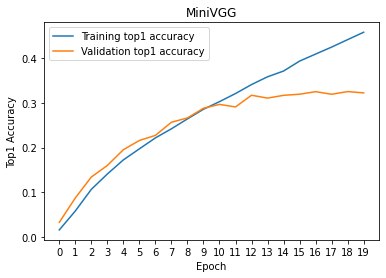

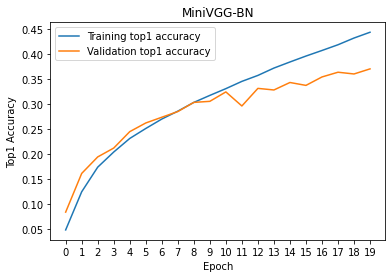

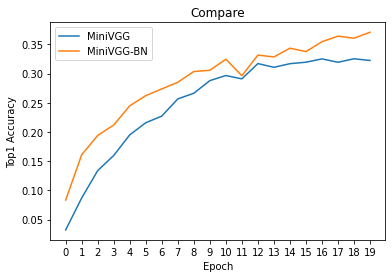

In [ ]:
x = np.arange(num_epochs)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, torch.tensor(tr_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, torch.tensor(tr_his_BN, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

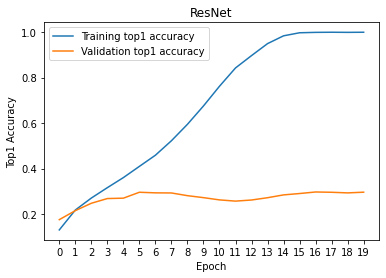

In [17]:
# For EECS 504 students only other please delete/comment this cell
x = np.arange(num_epochs)
# train/val accuracies for ResNet
plt.figure()
plt.plot(x, torch.tensor(tr_his_res, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_res, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('ResNet')
plt.show()

### TODO: __Summarize the effect of batch normalization:__
Below are the inferences drawn from observing above accuracy figures and the training loss in the tqdm progress bar for addition of Batch Normalization (BN).

1) Because of the BN, validation accuracies for MiniVGG-BN model are almost always, higher than MiniVGG model.

2) The BN helps MiniVGG-BN model to converge (to higher accuracies) faster than MiniVGG model.






In [ ]:
pickle.dump(tr_his, open('tr_his.pkl', 'wb'))
pickle.dump(tr_his_BN, open('tr_his_BN.pkl', 'wb'))
pickle.dump(val_his, open('val_his.pkl', 'wb'))
pickle.dump(val_his_BN, open('val_his_BN.pkl', 'wb'))

In [18]:
pickle.dump(tr_his_res, open('tr_his_res.pkl', 'wb'))
pickle.dump(val_his_res, open('val_his_res.pkl', 'wb'))

## Step 6. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [19]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values 
    of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the 
                network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [ ]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####
vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

Top-1 accuracy 36.33%, Top-5 accuracy 66.94%
Top-1 accuracy 31.7%, Top-5 accuracy 61.06%


In [20]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####

# For EECS 504 students only other please delete/comment this cell

resnet.load_state_dict(torch.load('./weights/ResNet.pth'))
test(resnet, dataloaders['test'])

Top-1 accuracy 29.31%, Top-5 accuracy 57.35%


# Convert Notebook to PDF


In [ ]:
import os
from google.colab import drive
from google.colab import files

drive_mount_point = '/content/drive/'
drive.mount(drive_mount_point)

Mounted at /content/drive/


In [ ]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!

# Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS_442_PS4_FA_2022_Starter_Code.ipynb'
notebookpath = '/content/drive/My Drive/Colab Notebooks/PS5_beprado.ipynb' 

file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
files.download(notebookpath.split('.')[0]+'.pdf')

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

FileNotFoundError: ignored

[Alternative, if the above cell doesn't work.](https://docs.google.com/document/d/1QTutnoApRow8cOxNrKK6ISEkA72QGfwLFXbIcpvarAI/edit?usp=sharing).